In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
import os
import cv2
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import pandas as pd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

## Data Preparation

### Loading Data 

In [ ]:
root_directory = "Semantic segmentation dataset"
patch_size = 256
scaler = MinMaxScaler()

image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname= path.split(os.path.sep)[-1]
    if dirname == "images":
        images = os.listdir(path)
     #   print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+os.path.sep+image_name,cv2.IMREAD_COLOR)
                image_before_crop = image
                image_before_crop = Image.fromarray(image_before_crop)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image_after_crop = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image_after_crop)

                #Extract patches from each image
                print("Now patchifying image: ",path,"/",image_name)
                patches_img = patchify(image, (patch_size,patch_size,3),step=256)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:].squeeze()
                        #print(single_patch_img.shape[-1])
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

Mask Dataset

In [ ]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:].squeeze()

                        mask_dataset.append(single_patch_mask) 

In [ ]:
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


In [ ]:
mask_dataset.shape, image_dataset.shape

In [ ]:
mask_dataset.dtype,image_dataset.dtype

## Image And Mask Saved in Files

In [ ]:
import torch
import torchvision
from pathlib import Path

# Örnek image dataset (örnek olarak random tensörler oluşturulmuştur)
# Sizin datasetiniz bu şekildedir diye varsayıyorum.
# Eğer numpy array ise `torch.tensor` kullanarak tensöre dönüştürmelisiniz.
# image_dataset = ...

# Şekli [1305, 256, 256, 3] olan dataset
# Klasör oluşturma
FOLDER_PATH = Path("ImageDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i in range(image_dataset.shape[0]):
    FILE_NAME = Path(f"image_{i}.jpg")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    
    # Görüntüyü kaydetme
    image = image_dataset[i]
    image = (image * 255).astype(np.uint8)
    mask = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.imwrite(FILE_PATH,image)

print(f"Images saved in {FOLDER_PATH}")


In [ ]:
image.shape

In [ ]:
import torch
import torchvision
from pathlib import Path

# Örnek image dataset (örnek olarak random tensörler oluşturulmuştur)
# Sizin datasetiniz bu şekildedir diye varsayıyorum.
# Eğer numpy array ise `torch.tensor` kullanarak tensöre dönüştürmelisiniz.
# image_dataset = ...

# Şekli [1305, 256, 256, 3] olan dataset
# Klasör oluşturma
FOLDER_PATH = Path("MaskDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i in range(mask_dataset.shape[0]):
    FILE_NAME = Path(f"image_{i}.png")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    
    # [H, W, C] -> [C, H, W] formatına permute etme
    mask = mask_dataset[i]
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)

    # Görüntüyü kaydetme
    cv2.imwrite(filename=FILE_PATH,img=mask)

print(f"Maskes saved in {FOLDER_PATH}")


In [ ]:
mask_dataset.shape,mask.shape,type(mask)

In [ ]:
#IOU

In [ ]:
image_dataset.shape

Image Generation for Chechk

In [ ]:
image_test = cv2.imread("ImageDataset//image_0.jpg")
mask_test = cv2.imread("MaskDataset//image_0.png")

In [ ]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_test, (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_test, (patch_size, patch_size, 3)))
plt.show()

Pathcing

In [ ]:
patches_img
plt.imshow(patches_img[2,1].squeeze())
patches_img[2,1].squeeze().shape

Crop

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(image_before_crop)
plt.title("Image Before Crop")
plt.subplot(1,2,2)
plt.imshow(image_after_crop)
plt.title("Image After Crop")

### Calculating RGB from HEX: #3C1098

    R = 201/16 = 12 with remainder of 9. So hex dode for R is C9 (remember C=12)

    3C = 3*16 + 12 = 60
    10 = 1*16 + 0 = 16
    90 = 9*16 + 8 = 152


    Building: #3C1098
    Land (unpaved area): #8429F6
    Road: #6EC1E4
    Vegetation: #FEDD3A
    Water: #E2A929
    Unlabeled: #9B9B9B

In [ ]:
a = int("3C",16) #3C with base 15. Should return 60.
a

In [ ]:
Building = "#3C1098".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Building[i:i+2],16))
Building = np.array(temp_list)
temp_list.clear()

Land = "#8429F6".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Land[i:i+2],16))
Land = np.array(temp_list)
temp_list.clear()

Road = "#6EC1E4".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Road[i:i+2],16))
Road = np.array(temp_list)
temp_list.clear()

Vegetation = "#FEDD3A".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Vegetation[i:i+2],16))
Vegetation = np.array(temp_list)
temp_list.clear()

Water = "#E2A929".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Water[i:i+2],16))
Water = np.array(temp_list)
temp_list.clear()

Unlabeled = "#9B9B9B".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Unlabeled[i:i+2],16))
Unlabeled = np.array(temp_list)
temp_list.clear()


In [ ]:
Building,Land,Road,Vegetation,Water,Unlabeled

In [ ]:
label = single_patch_mask
print("Color values of single patch mask : \n",label[2])

    Learn This Syntax
    Building = #3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

In [ ]:
def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    new_label = np.zeros(label_seg.shape + (num_class,))

    for i in range(num_class):
        new_label[label_seg == i,i] = 1   
    label_seg=new_label
    return label_seg

In [ ]:
mask.shape

In [ ]:
ex = rgb_to_2D_label(mask)
ex.shape

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels.shape

In [ ]:
"""FOLDER_PATH = Path("ProcessedMaskDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i, label in enumerate(labels):
    FILE_NAME = Path(f"image_{i}")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    np.save(FILE_PATH,label)"""

In [ ]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

OneHotEncoding

In [ ]:
"""ohe = OneHotEncoder(sparse_output=False)
encoded_labels = ohe.fit_transform(labels.flatten().reshape(-1,1))
encoded_labels = encoded_labels.reshape((1305,256,256,6))
encoded_labels.shape"""

In [124]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

torch.manual_seed(42)
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.maskes = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.maskes[idx])
        
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        #print(f"image shape : {image.shape}, mask shape: {mask.shape}")
        """
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.imshow(image)
        plt.subplot(122)
        plt.imshow(mask)
        plt.show()
        """
        label = rgb_to_2D_label(mask)

        image = torch.from_numpy(image)
        label = torch.from_numpy(label)

        image = image.permute((2,0,1))
        label = label.permute((2,0,1))
        
        return image, label
    

BATCH_SIZE = 2
# Dataset ve DataLoader oluşturma
image_dir = 'ImageDataset'
mask_dir = 'MaskDataset'
dataset = SegmentationDataset(image_dir, mask_dir)
train_size = int(0.6*len(dataset))
test_val_size  = len(dataset) - train_size

train_dataset, test_val_set = torch.utils.data.random_split(dataset, [train_size, test_val_size])
test_dataset, val_dataset = torch.utils.data.random_split(test_val_set,[0.5,0.5])
print("Length of \nTrain:",len(train_dataset),"Test:",len(test_dataset),"Valid:",len(val_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle = True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
# Dataloader kullanarak veri yükleme
#for images, masks in dataloader:
#    print(images.shape, masks.shape)


Length of 
Train: 783 Test: 261 Valid: 261


In [ ]:
for images, masks in train_loader:
    print(images.shape)  # Should be (BATCH_SIZE, 3, 256, 256)
    print(masks.shape)   # Should be (BATCH_SIZE, 3, 256, 256)
    break

In [ ]:
num_batches = 16
for batch_idx, (img, mask) in enumerate(train_loader):
    img0 = img
    mask0 = mask 

In [ ]:
"""import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

torch.manual_seed(42)
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.maskes = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.maskes[idx])
        image = Image.open(img_path).convert("RGB")
        mask = np.load(mask_dir)
        print(mask)
        image = np.array(image)
        #label = rgb_to_2D_label(mask)

        image = np.transpose(image,(2,0,1))
        mask = np.transpose(mask,(2,0,1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

# Dönüşümler
transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 8
# Dataset ve DataLoader oluşturma
image_dir = 'ImageDataset'
mask_dir = 'ProcessedMaskDataset'
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.6*len(dataset))
test_val_size  = len(dataset) - train_size

train_dataset, test_val_set = torch.utils.data.random_split(dataset, [train_size, test_val_size])
test_dataset, val_dataset = torch.utils.data.random_split(test_val_set,[0.5,0.5])
print("Length of \nTrain:",len(train_dataset),"Test:",len(test_dataset),"Valid:",len(val_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
# Dataloader kullanarak veri yükleme
#for images, masks in dataloader:
#    print(images.shape, masks.shape)
"""

In [ ]:
def show_image_and_mask(image,mask):
    image = torch.from_numpy(image)
    mask = torch.from_numpy(mask)
    image = image.permute(1,2,0)
    mask = image.permute(1,2,0)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(np.reshape(image,(patch_size,patch_size,3)))
    plt.subplot(122)
    plt.imshow(np.reshape(mask, (patch_size, patch_size, 6)))
    plt.show()

In [ ]:
def bilmemne(img,mask):
    print(f"size : {img.shape},{mask.shape}")
    mask = torch.from_numpy(mask)
    mask = mask.permute(1,2,0)
    img = torch.from_numpy(img)
    img = img.permute(1,2,0)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(np.reshape(img,(256,256,3)))

    plt.subplot(122)
    plt.imshow(np.reshape(mask,(256,256,3)))
    plt.show()


In [ ]:
img0 = img0.squeeze()
mask0 = mask0.squeeze()

image = img0.permute(1,2,0)
mask = mask0.permute(1,2,0)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image,(patch_size,patch_size,3)))
plt.subplot(122)
#plt.imshow(np.reshape(mask, (patch_size, patch_size, 6)))


## Defining Model

In [123]:
import torch.nn as nn
import torch
import torchvision


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), 
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2) 
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        self.conv10 = nn.Conv2d(64, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)  
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)

        out = self.sigmoid(c10)
        return out

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

In [ ]:
test()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [125]:
#class CNNmodel(nn.Module):
unet_model = UNET(in_channels=3,out_channels=6)
unet_model.to(device)
model = UNet(3,6)
model.to(device)

UNet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  

### Loss And Optim

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0

        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss

In [ ]:
def calculate_accuracy(predictions, targets, threshold=0.5):
    # Binarize predictions
    binarized_preds = (predictions > threshold).float()
    
    # Calculate accuracy
    correct_pixels = (binarized_preds == targets).sum()
    total_pixels = targets.numel()
    accuracy = correct_pixels.float() / total_pixels
    
    return accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define Cross-Entropy Loss
loss_fn = DiceLoss()
loss = nn.CrossEntropyLoss()
# Define Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [ ]:
Train_Accuracy_Score = 0.0
Train_F1_Score = 0.0
Train_Recall_Score = 0.0
Train_Precision_Score = 0.0

In [126]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    Train_Accuracy_Score = 0
    Train_F1_Score = 0
    Train_Recall_Score = 0
    Train_Precision_Score = 0
    train_acc = 0

    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)  # Ensure ground truth is in the right format
        #print(f"x: {x},{x.shape} \ny: {y},{y.shape}\n")
        optimizer.zero_grad()
        y_pred = model(x)
        #print(f"y_pred: {y_pred},{y_pred.shape}\n")
        loss = loss_fn.calculate_average_dice_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Convert predictions to class indices using softmax
        y_pred_probs = torch.softmax(y_pred,dim=1)  # Convert logits to probabilities
        #print(f"softmax:y_pred_probs: {y_pred_probs},{y_pred_probs.shape}")
        
        #y_pred_class = torch.argmax(y_pred_probs,dim=1)  # Get class indices from probabilities
        #print(f"argmax:y_pred_class: {y_pred_class},{y_pred_class.shape}")
        # Flatten the arrays for metric calculation
        y_np = y.cpu().numpy().flatten()
        #y_pred_np = y_pred_class.cpu().numpy().flatten()
        #print(f"y_pred_np: {y_pred_np},{y_pred_np.size}")
        #print(f"y_np: {y_np},{y_np.size}")
        
        # Calculate metrics for each class
        train_acc += calculate_accuracy(y_pred,y)
        #Train_Accuracy_Score += accuracy_score(y_np,y_pred_np)
        #Train_F1_Score += f1_score(y_np, y_pred_np, average='macro')
        #Train_Recall_Score += recall_score(y_np, y_pred_np, average='macro')
        #Train_Precision_Score += precision_score(y_np, y_pred_np, average='macro')
    num_batches = len(loader)

    return (epoch_loss / num_batches, 
            #Train_Accuracy_Score / num_batches, 
            #Train_F1_Score / num_batches, 
            #Train_Recall_Score / num_batches, 
            #Train_Precision_Score / num_batches,
            train_acc/num_batches)

Epoch 1/30, Train Loss: 0.8842, Train_Accuracy_Score: , Train_F1_Score:, Train_Recall_Score: , Train_Precision_Score: , Acc: 0.3523736894130707
Current Loss: 0.7556, Train_Accuracy_Score: , Train_F1_Score: , Train_Recall_Score: , Train_Precision_Score: Val_acc : 0.3527145981788635


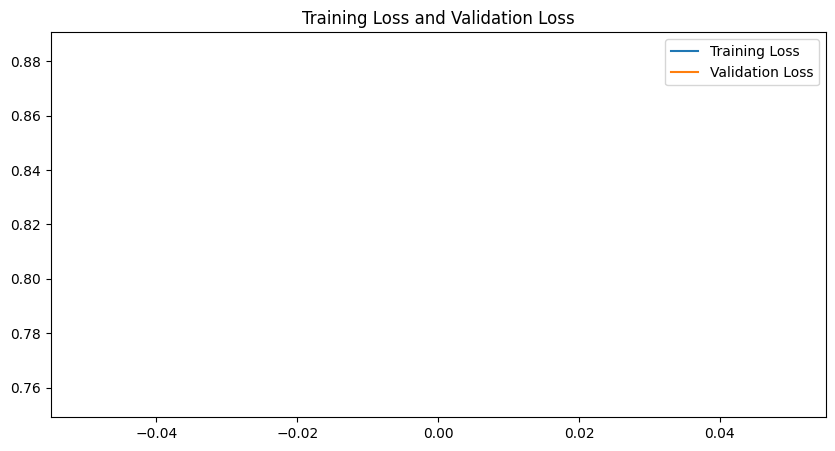

KeyboardInterrupt: 

In [128]:
from IPython.display import clear_output
train_losses = []
cross_losses = []
bestScore=float('inf')
num_epochs = 30
for epoch in range(num_epochs):
    #, Train_Accuracy_Score, Train_F1_Score, Train_Recall_Score, Train_Precision_Score
    #, Val_Accuracy_Score, Val_F1_Score, Val_Recall_Score, Val_Precision_Score
    train_loss, train_acc= train(model,train_loader,loss_fn,optimizer,device)
    Current_loss, val_acc = validate(model,train_loader,loss_fn,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train_Accuracy_Score: , Train_F1_Score:, Train_Recall_Score: , Train_Precision_Score: , Acc: {train_acc}')
    print(f'Current Loss: {Current_loss:.4f}, Train_Accuracy_Score: , Train_F1_Score: , Train_Recall_Score: , Train_Precision_Score: Val_acc : {val_acc}')
    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(),checkpoints_path)

In [127]:
def validate(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0.0
    Val_Accuracy_Score = 0.0
    Val_F1_Score = 0.0
    Val_Recall_Score = 0.0
    Val_Precision_Score = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)  # Ensure ground truth is in the right format
            
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            # Convert predictions to class indices
            #y_pred_class = torch.argmax(y_pred, dim=1)
            #print(y.scale(),y_pred.scale())
            # Flatten the arrays for metric calculation
            #y_np = y.cpu().numpy()
            #y_pred_np = y_pred_class.cpu().numpy()
            
            test_acc += calculate_accuracy(y_pred,y)

            # Calculate metrics for each class
            #Val_Accuracy_Score += accuracy_score(y_np,y_pred_np)
            #Val_F1_Score += f1_score(y_np, y_pred_np, average='macro')
            #Val_Recall_Score += recall_score(y_np, y_pred_np, average='macro')
            #Val_Precision_Score += precision_score(y_np, y_pred_np, average='macro')

            epoch_loss += loss.item()

    # Average the metrics over all batches
    num_batches = len(loader)

    return (epoch_loss / num_batches, 
            #Val_Accuracy_Score / num_batches, 
            #Val_F1_Score / num_batches, 
            #Val_Recall_Score / num_batches, 
            #Val_Precision_Score / num_batches,
            test_acc / num_batches)

In [ ]:
from pathlib import Path
checkpoints_path = Path("Checkpoint.pth")

In [104]:
from IPython.display import clear_output
train_losses = []
cross_losses = []
bestScore=float('inf')
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train(unet_model,train_loader,loss,optimizer,device)
    Current_loss = validate(unet_model,val_loader,loss,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)
    
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch

    
    

AttributeError: 'CrossEntropyLoss' object has no attribute 'calculate_average_dice_loss'

    import torch
    import torch.nn.functional as F

    def dice_loss(pred, target, smooth=1.0):
        pred = F.softmax(pred, dim=1)
        intersection = (pred * target).sum(dim=[2, 3])
        union = pred.sum(dim=[2, 3]) + target.sum(dim=[2, 3])
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def combined_loss(pred, target, alpha=0.5, smooth=1.0):
        ce_loss = nn.CrossEntropyLoss()(pred, target)
        dice = dice_loss(pred, target, smooth)
        return alpha * ce_loss + (1 - alpha) * dice

In [117]:
for batch_idx, (img, mask) in enumerate(train_loader):
    continue
print(batch_idx,img.shape,mask.shape)

KeyboardInterrupt: 

In [129]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

model = UNet(3,6)
model.load_state_dict(torch.load(checkpoints_path, map_location=device))

img_num = "43"

def show_prediction(img_num):
    transform = transforms.Compose([
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])


    img = cv2.imread(f"ImageDataset//image_{img_num}.jpg")

    patch_size = 256
    SIZE_X = (img.shape[1]//patch_size)*patch_size
    SIZE_Y = (img.shape[0]//patch_size)*patch_size
    img = Image.fromarray(img)
    large_img = img.crop((0,0,SIZE_X,SIZE_Y))
    large_img = np.array(large_img)

    patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)
    patches_img = patches_img[:, :, 0, :, :, :]

    patched_prediction = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            single_patch_tensor = torch.from_numpy(single_patch_img).float()
            single_patch_tensor /= 255.0
            single_patch_tensor = single_patch_tensor.permute(2, 0, 1)

            single_patch_tensor = transform(single_patch_tensor).unsqueeze(0)  

            with torch.no_grad():
                pred = model(single_patch_tensor)
            pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
            patched_prediction.append(pred)

    patched_prediction = np.array(patched_prediction)
    patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patch_size, patch_size])

    unpatched_prediction = unpatchify(patched_prediction, (SIZE_Y, SIZE_X))
    load_images(unpatched_prediction,img_num)

In [119]:
def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

In [130]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

def load_images(unpatched_prediction,img_num):

    # Load the images
    G_img = Image.open(f"ImageDataset//image_{img_num}.jpg")
    REAL_img = Image.open(f"MaskDataset//image_{img_num}.png")

    # Define patch size and adjust the size of G_img
    patch_size = 256
    SIZE_X = (G_img.size[0] // patch_size) * patch_size
    SIZE_Y = (G_img.size[1] // patch_size) * patch_size
    G_img = G_img.crop((0, 0, SIZE_X, SIZE_Y))
    G_img = np.array(G_img)


    patch_size = 256
    SIZE_X = (REAL_img.size[0] // patch_size) * patch_size
    SIZE_Y = (REAL_img.size[1] // patch_size) * patch_size
    REAL_img = REAL_img.crop((0, 0, SIZE_X, SIZE_Y))
    REAL_img = np.array(REAL_img)
    REAL_img = np.array(REAL_img)


    prediction = label_to_rgb(unpatched_prediction)

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(G_img)
    plt.title("The Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(REAL_img)
    plt.title("Real Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

In [131]:
# IOU, Recall, Precision, F1Score, Acurracy, Onehot olmadan alternatif, Datset Dataloader örnekleri Augmentasion

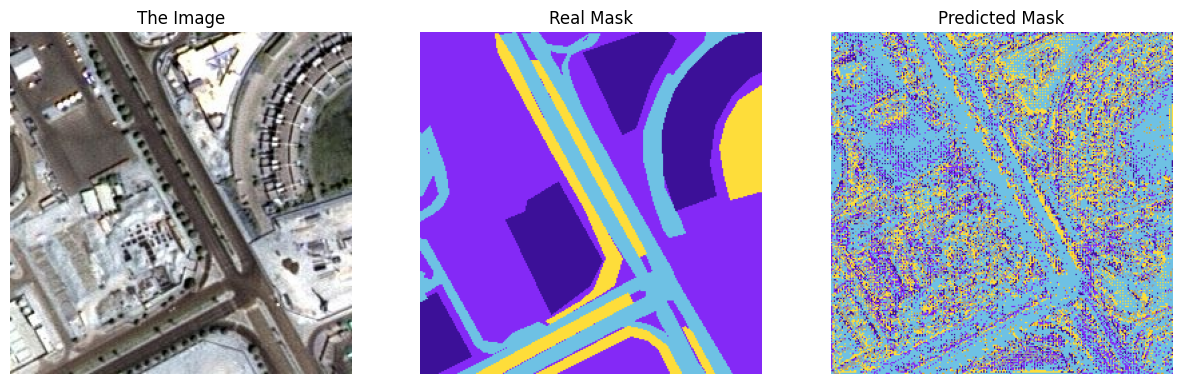

In [143]:
import random
random_int = random.randint(0,1305)
show_prediction(random_int)